## Optional models to the main Project:  ICU Predictions Sirio Libanes

Here I am implementing in these three datasets, as experimental machine learning models to see how it behaves.
It was a alternative option to try to predict ICU admission to specific groups as suggested in the Initial proposal of Sirio Libanes team. 

### Problem Question:
Based on the available data could a Machine Learning model predict whether the patient will need intensive care unit (ICU)?

•	Using Vital signs + Demographics features?

•	Using Laboratory exams + Demographics?

•	Using Comorbidities + Demographics?

The Three datasets used here were created after had defined window and ICU admission, but its not eliminating the high correlations.

In [1]:
import pandas as pd
import numpy as np 


import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score 
from sklearn.metrics import r2_score,roc_auc_score,roc_curve, auc, recall_score,make_scorer
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# XAI
import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

#Extras
import warnings
warnings.filterwarnings('ignore')

In [2]:
def run_test_models(data):
  
    X_columns = data.columns
    y = data['ICU']
    X = data[X_columns].drop(['ICU'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y, random_state= 67235)

    results = []
    np.random.seed(67235)
    for model in [DummyClassifier,LogisticRegression,GaussianNB,
                SVC,RandomForestClassifier,GradientBoostingClassifier]:



                model_used = model()

                kfold = StratifiedKFold(n_splits=5,shuffle=True)
                val_score = model_selection.cross_val_score(model_used,X,y,scoring='roc_auc',
                                                            cv = kfold)
                
                results.append(f'{model.__name__:22} AUC:\
                {val_score.mean():.3f} STD: {val_score.std():.2f}')    

    return results


def plot_cm(y_test, y_pred, figsize=(8,8)):
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    


In [3]:
def grid_search_cv(parameters, model, X_train, y_train):

    findGrid = GridSearchCV(model, param_grid=parameters, cv=10, scoring='roc_auc')
  
      # Train the model
    findGrid.fit(X_train, y_train)

    #Find the best parameters
    best_params = findGrid.best_params_

    return best_params


def graphic_boost(title:str, x_label: str, y_label: str):
    '''
    Define graphic descriptions

    title: Graphic title
    x_label: description of axes X
    y_label: description axes y
  '''
    plt.title(title, loc='left', fontsize=24)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18);

# 1. Model  build in with Vital Signs and  Demographic features

In [4]:
vital_signs = pd.read_csv('vital_signsAndDemographic.csv', index_col=0)
vital_signs.head()

,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,...,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,AGE_ABOVE65,GENDER,ICU
0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,...,0,0,1,0,0,0,0,1,0,1
2,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,...,0,0,0,0,0,0,0,0,0,1
3,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,...,1,0,0,0,0,0,0,0,1,0
4,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,...,0,0,0,0,0,0,0,0,0,0
5,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.037037,-0.538462,-0.537736,-0.517241,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Work with vital_signs dataframe
X_columns = vital_signs.columns
y = vital_signs['ICU']
X = vital_signs[X_columns].drop(['ICU'], axis=1)

#Split train and test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y,random_state= 67235)

In [6]:
run_test_models(vital_signs)

['DummyClassifier        AUC:                0.509 STD: 0.03',
 'LogisticRegression     AUC:                0.712 STD: 0.05',
 'GaussianNB             AUC:                0.691 STD: 0.06',
 'SVC                    AUC:                0.718 STD: 0.05',
 'RandomForestClassifier AUC:                0.681 STD: 0.08',
 'GradientBoostingClassifier AUC:                0.653 STD: 0.06']

## SVC Model

In [7]:
parameters = {
            'C': [0.01, 1, 5],
            'coef0': [1.0, 10.0],
            'degree': [1,2,5],
            'gamma': [000.1, 0.001, 0.01, 0.1, 1],
            'kernel': ['poly','linear','rbf']
            }

grid_search_cv = GridSearchCV(SVC(), parameters, scoring = 'accuracy', cv=10)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.01, 1, 5], 'coef0': [1.0, 10.0],
                         'degree': [1, 2, 5],
                         'gamma': [0.1, 0.001, 0.01, 0.1, 1],
                         'kernel': ['poly', 'linear', 'rbf']},
             scoring='accuracy')

In [8]:
grid_search_cv.best_estimator_

SVC(C=1, coef0=10.0, degree=2, gamma=0.001, kernel='poly')

In [9]:
grid_search_cv.best_score_

0.6607142857142858

In [10]:
svm = SVC(C=10, coef0=10.0, degree=10, gamma=0.1, kernel='rbf', random_state=62375)
svm.fit(X_train,y_train)
train_score = svm.score(X_train, y_train)
train_score

0.8071428571428572

In [11]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        38
           1       0.68      0.66      0.67        32

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.70      0.70      0.70        70



### Confusion Matrix

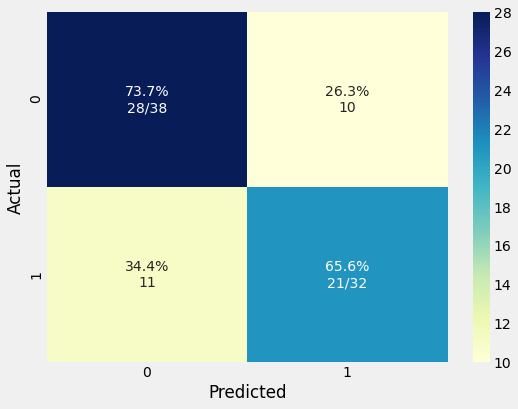

In [12]:
plot_cm(y_test, y_pred, figsize=(8,6))

In [13]:
perm = PermutationImportance(svm, scoring = 'recall', random_state=67235).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=10)

Weight,Feature
0.1062 ± 0.0935,AGE_ABOVE65
0.0813 ± 0.0306,AGE_PERCENTIL_Above 90th
0.0500 ± 0.0306,AGE_PERCENTIL_50th
0.0437 ± 0.0306,AGE_PERCENTIL_90th
0.0250 ± 0.0468,AGE_PERCENTIL_40th
0.0250 ± 0.0250,AGE_PERCENTIL_30th
0.0187 ± 0.0306,AGE_PERCENTIL_10th
0.0187 ± 0.0500,AGE_PERCENTIL_20th
0.0063 ± 0.0468,BLOODPRESSURE_DIASTOLIC_MIN
0.0063 ± 0.0468,TEMPERATURE_MIN


# 2. Model build in with Lab exams and Demographic features

In [14]:
lab_exams = pd.read_csv('lab_examsDemographic.csv', index_col=0)
lab_exams.head(3)

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,...,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,AGE_ABOVE65,GENDER,ICU
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,1,0,0,0,0,1,0,1
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,1
3,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1,0,0,0,0,0,0,0,1,0


In [15]:
#Work with lab_exams dataframe
X_columns = lab_exams.columns
y = lab_exams['ICU']
X = lab_exams[X_columns].drop(['ICU'], axis=1)

#Split train and test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,stratify=y, random_state= 67235)

In [16]:
run_test_models(lab_exams)

['DummyClassifier        AUC:                0.509 STD: 0.03',
 'LogisticRegression     AUC:                0.753 STD: 0.04',
 'GaussianNB             AUC:                0.715 STD: 0.05',
 'SVC                    AUC:                0.773 STD: 0.06',
 'RandomForestClassifier AUC:                0.749 STD: 0.04',
 'GradientBoostingClassifier AUC:                0.745 STD: 0.07']

### SVC Model

In [ ]:
parameters_lab = {
            'C': [0.01, 1, 5],
            'coef0': [1.0, 10.0],
            'degree': [1,2,5],
            'gamma': [000.1, 0.001, 0.01, 0.1, 1],
            'kernel': ['poly','linear','rbf']
            }

grid_search_cv = GridSearchCV(SVC(), parameters_lab, scoring = 'accuracy', cv=10)
grid_search_cv.fit(X_train, y_train)

In [17]:
grid_search_cv.best_estimator_

In [18]:
grid_search_cv.best_score_

In [19]:
svm_lab = SVC(C=1, coef0=1.0, degree=1, gamma=0.1, kernel='poly', random_state=62375)
svm_lab.fit(X_train,y_train)
train_score = svm_lab.score(X_train, y_train)
train_score

0.7321428571428571

In [20]:
y_pred = svm_lab.predict(X_test)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        38
           1       0.75      0.75      0.75        32

    accuracy                           0.77        70
   macro avg       0.77      0.77      0.77        70
weighted avg       0.77      0.77      0.77        70



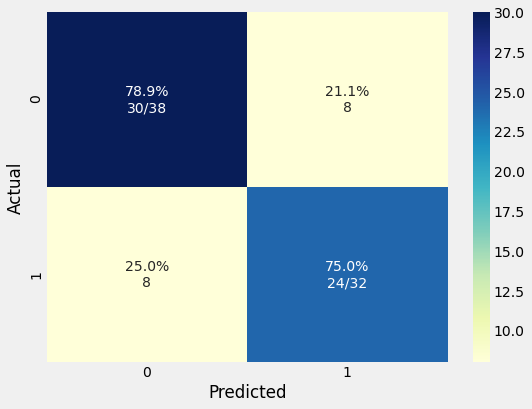

In [21]:
plot_cm(y_test, y_pred, figsize=(8,6))

# 3. Model build in with Disease group and demographic features

Patients with COVID-19 disease who have comorbidities, such as hypertension or diabetes mellitus, are more likely to develop a more severe course and progression of the disease. Furthermore, older patients, especially those 65 years old and above who have comorbidities and are infected, have an increased admission rate into the intensive care unit (ICU).

In [22]:
disease_group = pd.read_csv('diseasesDemographic.csv', index_col=0)
disease_group.head()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,AGE_PERCENTIL_10th,...,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,AGE_ABOVE65,GENDER,ICU
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,...,0,0,1,0,0,0,0,1,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,...,1,0,0,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Work with disease_group dataframe
X_columns = disease_group.columns
y = disease_group['ICU']
X = disease_group[X_columns].drop(['ICU'], axis=1)

#Split train and test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,stratify=y, random_state= 67235)

In [24]:
run_test_models(disease_group)

['DummyClassifier        AUC:                0.509 STD: 0.03',
 'LogisticRegression     AUC:                0.671 STD: 0.03',
 'GaussianNB             AUC:                0.681 STD: 0.06',
 'SVC                    AUC:                0.677 STD: 0.03',
 'RandomForestClassifier AUC:                0.657 STD: 0.02',
 'GradientBoostingClassifier AUC:                0.691 STD: 0.06']

### SVC MODEL

In [25]:
parameters = {
            'C': [0.01, 1, 5],
            'coef0': [1.0, 10.0],
            'degree': [1,2,5],
            'gamma': [000.1, 0.001, 0.01, 0.1, 1],
            'kernel': ['poly','linear','rbf']
            }

grid_search_cv = GridSearchCV(SVC(), parameters, scoring = 'accuracy', cv=10)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.01, 1, 5], 'coef0': [1.0, 10.0],
                         'degree': [1, 2, 5],
                         'gamma': [0.1, 0.001, 0.01, 0.1, 1],
                         'kernel': ['poly', 'linear', 'rbf']},
             scoring='accuracy')

In [26]:
grid_search_cv.best_estimator_

SVC(C=1, coef0=1.0, degree=1, gamma=0.1, kernel='poly')

In [27]:
grid_search_cv.best_score_

0.6321428571428572

In [28]:
svm = SVC(C=10, coef0=10, degree=4, gamma=0.01, kernel='rbf', random_state=62375)
svm.fit(X_train,y_train)
train_score = svm.score(X_train, y_train)
train_score

0.6464285714285715

In [29]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68        38
           1       0.62      0.72      0.67        32

    accuracy                           0.67        70
   macro avg       0.67      0.68      0.67        70
weighted avg       0.68      0.67      0.67        70



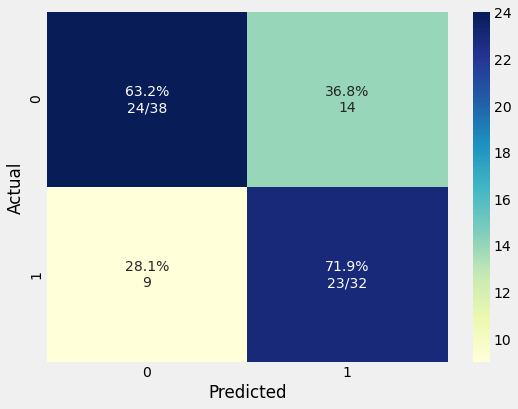

In [30]:
plot_cm(y_test, y_pred, figsize=(8,6))

In [31]:
perm = PermutationImportance(svm, scoring = 'recall', random_state=67235).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=10)

Weight,Feature
0.1125 ± 0.1225,AGE_ABOVE65
0.0312 ± 0.0000,DISEASE GROUPING 3
0.0125 ± 0.0306,AGE_PERCENTIL_10th
0.0125 ± 0.0306,DISEASE GROUPING 1
0.0063 ± 0.0250,AGE_PERCENTIL_20th
0.0063 ± 0.0250,GENDER
0.0063 ± 0.0250,AGE_PERCENTIL_50th
0.0063 ± 0.0250,AGE_PERCENTIL_40th
0 ± 0.0000,DISEASE GROUPING 4
0 ± 0.0000,DISEASE GROUPING 6


## Train Random Forest Classifier

In [32]:
parameters = {
            'n_estimators':[5,10,20], 
            'criterion':['entropy', 'gini'],
            'max_depth':[1,2,3,4,5,6,7,8,9,10],
            'max_features':['sqrt','log2', 'auto'],
            'bootstrap': ['True', 'False'],
            'oob_score': ['True', 'False'],   
}


grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'accuracy')
grid_search_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': ['True', 'False'],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'n_estimators': [5, 10, 20],
                         'oob_score': ['True', 'False']},
             scoring='accuracy')

In [33]:
grid_search_cv.best_estimator_

RandomForestClassifier(bootstrap='True', criterion='entropy', max_depth=2,
                       n_estimators=5, oob_score='True')

In [34]:
grid_search_cv.best_score_

0.6678571428571429

In [43]:
rfc=RandomForestClassifier(bootstrap='True', criterion='entropy', max_depth=12,
                       n_estimators=6, max_features='sqrt', random_state=67235)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

0.775

In [44]:
y_pred = rfc.predict(X_test)
print (classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        38
           1       0.67      0.69      0.68        32

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.70      0.70      0.70        70



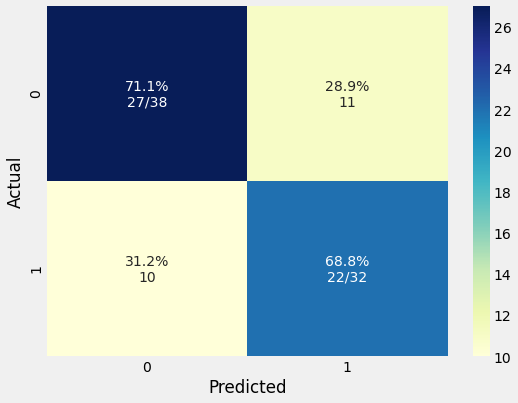

In [45]:
plot_cm(y_test, y_pred, figsize=(8,6))

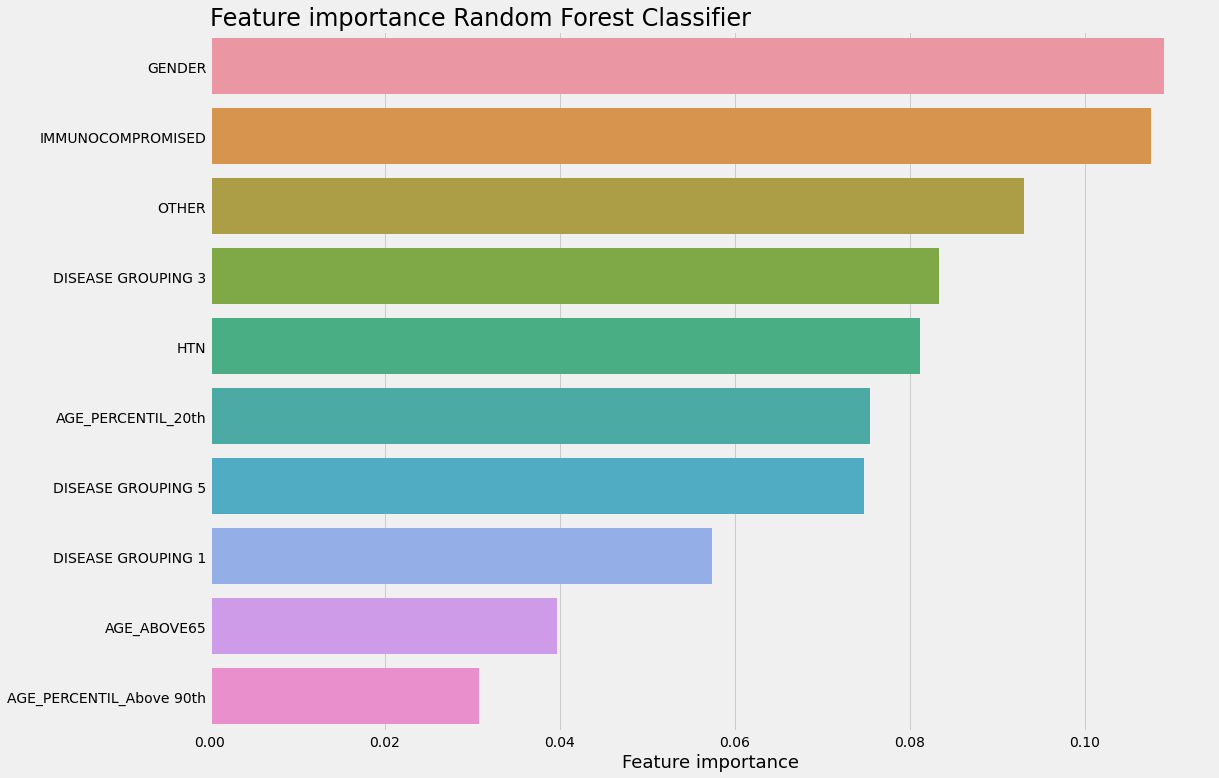

In [46]:
_ = pd.DataFrame({'feature_importance': rfc.feature_importances_,
                  'variavel': X_train.columns}).sort_values('feature_importance', ascending=False)
plt.figure(figsize=(16, 12))
sns.barplot(data=_[:10], y='variavel', x='feature_importance', orient='h')
graphic_boost('Feature importance Random Forest Classifier', 
                    'Feature importance', '')

In [47]:
models_name = ['RandomForestClassifier', 'SVC']
models = [rfc, svm]

def compare_roc_curves(X_train, y_train, X_test, y_test, models):
    fig, ax = plt.subplots(figsize=(8,6))
    
    for model in models:   
        model.fit(X_train, y_train)
        plot_roc_curve(model, X_test, y_test, ax=ax)
     
        ax.grid(linestyle='--')
        ax.set_ylabel('TPR', fontsize=18)
        ax.set_xlabel('FPR', fontsize=18)
        ax.set_title('Compare ROC curves - Test set for Disease groups and demographic features', fontsize=18)
        ax.legend(bbox_to_anchor=(1,1), fontsize='large', title='Classifiers:', title_fontsize=18, labelspacing=0.8); 

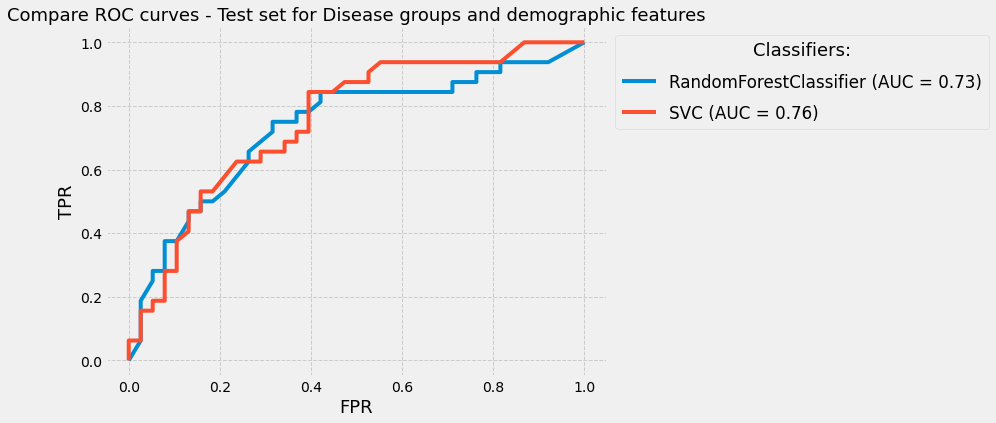

In [48]:
compare_roc_curves(X_train, y_train, X_test, y_test, models)